In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg

# Creating A

In [3]:
# def data_matrix(k, m, n):
#     extra_columns = n-k
#     extra_rows = m-k
#     return np.block([
#         [np.eye(k), np.zeros((k, extra_columns))],
#         [np.zeros((extra_rows, k)), np.zeros((extra_rows, extra_columns))],
#     ])

In [4]:
def contruct_rank_k_matrix(k, m, n):
    assert k < m and k < n
    columns = np.random.randn(m, k)
    first = np.arange(0, k)
    rand_select = np.random.randint(low=0, high=k, size=n-k)
    select = np.concatenate([first, rand_select])
    random_mat = columns[:, select]
    return random_mat

# Calculating c

In [5]:
def calculate_asymptotic_c(k, n, epsilon):
    """Approximate for large n."""
    n = float(n)
    if 0.0 < epsilon and epsilon <= 0.5 and k <= n:
        c = (k / epsilon ** 2)
        c *= np.log(k / epsilon)
        c *= np.log(n)
        return c
    else:
        raise ValueError("Epsilon must be between 0 and 1/2.")

def calculate_c(k, n, epsilon):
    n = float(n)
    epsilon *= 21
    c = 192 * k * np.log(40 * n * k) / epsilon ** 2
    c *= np.log((192 * np.sqrt(20) * k * np.log(40 * n * k)) / epsilon ** 2)
    return c

# The Selection Matrix

In [6]:
def selection_matrix(n, c):
    """Return a selection matrix of shape == (n, c)"""
    index_canonical_vectors = np.random.randint(low=0, high=n-1, size=c)
    canonical_vectors = np.zeros((n, c))
    for row, col in zip(index_canonical_vectors, range(c)):
        canonical_vectors[row, col] = 1.0
    return np.sqrt(n/c) * canonical_vectors

# The Randomized Hadamard Transform

In [7]:
# def hadamard_matrix(n):
#     if n == 2:
#         h2 = np.array([[1, 1],[1, -1]])
#         return h2
#     elif n % 2 == 0:
#         return np.block([
#             [hadamard_matrix(n/2), hadamard_matrix(n/2)], 
#             [hadamard_matrix(n/2), -hadamard_matrix(n/2)]
#         ])
#     else:
#         raise ValueError("n was not a power of two.")

def randomized_hadamard_transform(n):
    H_tilde = scipy.linalg.hadamard(n)
    H = np.sqrt(n) ** (-1) * H_tilde
    D = np.diag(np.random.randint(low=0, high=2, size=n) - 0.5)
    return D @ H

# Show c vs asymptotic c

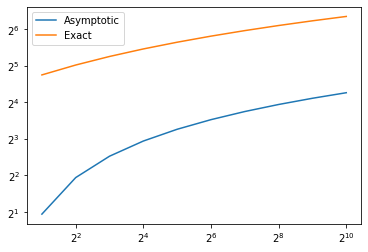

In [8]:
# Constant k
k = 1
epsilon = 0.5
min_n, max_n = 1, 10
expos = range(min_n, max_n + 1)


ns = [2 ** expo for expo in expos]
asym_cs = [calculate_asymptotic_c(k, n, epsilon) for n in ns]
cs = [calculate_c(k, n, epsilon) for n in ns]

fig, ax = plt.subplots()
ax.plot(ns, asym_cs, label="Asymptotic")
ax.plot(ns, cs, label="Exact")
ax.set_yscale('log', basey=2)
ax.set_xscale('log', basex=2)
ax.legend()
# fig.show()

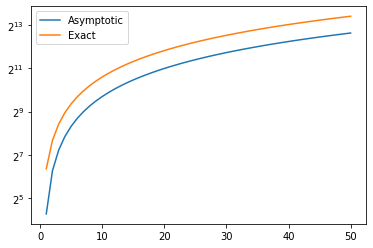

In [9]:
# Constant n
n = 2 ** 10
epsilon = 0.5
min_k, max_k = 1, 50
# expos = range(min_n, max_n + 1)
ks = range(min_k, max_k + 1)


# n = [2 ** expo for expo in expos]
asym_cs = [calculate_asymptotic_c(k, n, epsilon) for k in ks]
cs = [calculate_c(k, n, epsilon) for k in ks]

fig, ax = plt.subplots()
ax.plot(ks, asym_cs, label="Asymptotic")
ax.plot(ks, cs, label="Exact")
ax.set_yscale('log', basey=2)
# ax.set_xscale('log', basex=2)
ax.legend()
# fig.show()

# Error for kth best approximation

In [10]:
# Create Matrix
m = 2 ** 10
n = 2 ** 9
k_max = 5
noise_std = 0.1

A = contruct_rank_k_matrix(k_max, m, n)
A += np.random.randn(*A.shape) * noise_std
print(f"Matrix shape = {A.shape}")

Matrix shape = (1024, 512)


In [11]:
def kth_best_approx(A, k):
    if k-1 < 0:
        raise ValueError("Positive ks please.")
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    return np.dot(u[:, :k] * s[:k], vh[:k, :])

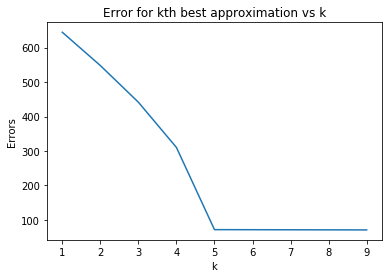

In [12]:
ks = [k for k in range(1, k_max + 5)]
errors = [np.linalg.norm(A - kth_best_approx(A, k)) for k in ks]

fig, ax = plt.subplots()
ax.plot(ks, errors, label="")
ax.set_title("Error for kth best approximation vs k")
ax.set_xlabel("k")
ax.set_ylabel("Errors");

# Error calc for random matricies

In [13]:
def u_tilde_k(c, k, A):
    m, n = A.shape
    S = selection_matrix(n, c)
    DH = randomized_hadamard_transform(n)
    C = np.linalg.multi_dot([A, DH, S])
    Uc, _, _ = np.linalg.svd(C, full_matrices=False)
    W = np.dot(Uc.T, A)
    if np.linalg.matrix_rank(W) < k:
        raise ValueError()
    U_w, _, _ = np.linalg.svd(W, full_matrices=False)
    U_wk = U_w[:, :k]
    U_tilde_k = np.dot(Uc, U_wk)
    return U_tilde_k

In [14]:
epsilon = 0.5
k_min = 1
ks = [k for k in range(k_min, k_max + 1)]
# cs = [int(np.ceil(calculate_c(k, n, epsilon))) for k in ks]

asym_cs = [int(np.ceil(calculate_asymptotic_c(k, n, epsilon))) for k in ks]
errors = np.asarray([np.linalg.norm(A - kth_best_approx(A, k)) for k in ks])
print(ks)
print(asym_cs)

[1, 2, 3, 4, 5]
[18, 70, 135, 208, 288]


In [15]:
samples = 25
utkss = []
for c, k in zip(asym_cs, ks):
    utks = []
    for _ in range(samples):
        utks.append(u_tilde_k(c, k, A))
    utkss.append(utks)

In [16]:
random_errorss = []
for utks in utkss:
    random_errors = []
    for utk in utks:
        random_errors.append(np.linalg.norm(A - np.linalg.multi_dot((utk, utk.T, A))))
    random_errorss.append(random_errors)
random_errorss = np.asarray(random_errorss)

In [17]:
epsilon_error = random_errorss/errors[:, None] - 1

Asymptotically calculated (k, c) pairs [(1, 18), (2, 70), (3, 135), (4, 208), (5, 288)]


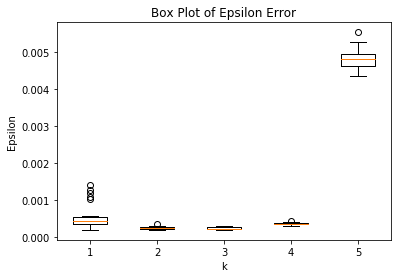

In [18]:
fig, ax = plt.subplots()
ax.set_title('Box Plot of Epsilon Error')
ax.set_ylabel('Epsilon')
ax.set_xlabel("k")
ax.set_xticklabels(ks)
ax.boxplot(epsilon_error.T);
print(f"Asymptotically calculated (k, c) pairs {list(zip(ks, asym_cs))}")